In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import requests
from pathlib import Path
from PIL import Image
from pkg_resources import packaging
from collections import Counter
from itertools import combinations
from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import average_precision_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

/tmp/ipykernel_35/3983547996.py:9: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging


In [2]:
def explode_df(df, col):
    df = df.explode(col).reset_index(drop=True)
    df = df.merge(pd.json_normalize(df[col]), left_index=True, right_index=True).drop(col, axis=1)
    return df

In [3]:
os.listdir('/kaggle/input/vizwiz-2023-edition/Annotations')

['train.json', 'test.json', 'val.json']

In [4]:
train_test = pd.read_json("/kaggle/input/vizwiz-2023-edition/Annotations/train.json", orient="records")
val = pd.read_json("/kaggle/input/vizwiz-2023-edition/Annotations/val.json", orient="records")

In [5]:
train_test['answerable_answer_type'] = train_test['answerable'].astype(str) + "_" + train_test['answer_type'].astype(str)

In [6]:
train, test, _, _ = train_test_split(train_test, train_test['answerable_answer_type'], test_size=0.05, random_state=42, stratify=train_test['answerable_answer_type'])

In [7]:
train.drop(columns=['answerable_answer_type'], inplace=True)
test.drop(columns=['answerable_answer_type'], inplace=True)

In [8]:
df = pd.concat([train, test, val])
df.reset_index(drop=True, inplace=True)
df

,image,question,answers,answer_type,answerable
0,VizWiz_train_00011239.jpg,What is this in the jar?,"[{'answer': 'empty', 'answer_confidence': 'may...",other,1
1,VizWiz_train_00016611.jpg,Tell me what you see in this photograph.,"[{'answer_confidence': 'yes', 'answer': 'bar'}...",other,1
2,VizWiz_train_00014090.jpg,"What is in this package, what kind of cake mix?","[{'answer_confidence': 'maybe', 'answer': 'una...",unanswerable,0
3,VizWiz_train_00010034.jpg,What is this?,"[{'answer_confidence': 'yes', 'answer': 'remot...",other,1
4,VizWiz_train_00014362.jpg,What do you see?,"[{'answer_confidence': 'yes', 'answer': 'unans...",unanswerable,0
...,...,...,...,...,...
24837,VizWiz_val_00004314.jpg,what is this?,"[{'answer_confidence': 'yes', 'answer': 'salad...",other,1
24838,VizWiz_val_00004315.jpg,Is this modern?,"[{'answer_confidence': 'maybe', 'answer': 'una...",unanswerable,0
24839,VizWiz_val_00004316.jpg,I need to buy this battery for my cordless pho...,"[{'answer_confidence': 'yes', 'answer': 'unans...",unanswerable,0
24840,VizWiz_val_00004317.jpg,What kind of mix is this?,"[{'answer_confidence': 'maybe', 'answer': 'cak...",other,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24842 entries, 0 to 24841
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        24842 non-null  object
 1   question     24842 non-null  object
 2   answers      24842 non-null  object
 3   answer_type  24842 non-null  object
 4   answerable   24842 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 970.5+ KB


In [10]:
df['answerable_answer_type'] = df['answerable'].astype(str) + "_" + df['answer_type'].astype(str)

In [11]:
explode_df(val, 'answers')

,image,question,answer_type,answerable,answer,answer_confidence
0,VizWiz_val_00000000.jpg,Ok. There is another picture I hope it is a be...,unanswerable,0,unanswerable,yes
1,VizWiz_val_00000000.jpg,Ok. There is another picture I hope it is a be...,unanswerable,0,unanswerable,yes
2,VizWiz_val_00000000.jpg,Ok. There is another picture I hope it is a be...,unanswerable,0,unanswerable,yes
3,VizWiz_val_00000000.jpg,Ok. There is another picture I hope it is a be...,unanswerable,0,unanswerable,yes
4,VizWiz_val_00000000.jpg,Ok. There is another picture I hope it is a be...,unanswerable,0,unanswerable,maybe
...,...,...,...,...,...,...
43185,VizWiz_val_00004318.jpg,What kind of spice is this?,other,1,masala,maybe
43186,VizWiz_val_00004318.jpg,What kind of spice is this?,other,1,unanswerable,yes
43187,VizWiz_val_00004318.jpg,What kind of spice is this?,other,1,garam marsala,yes
43188,VizWiz_val_00004318.jpg,What kind of spice is this?,other,1,masala,maybe


In [12]:
df3 = explode_df(df, 'answers')
df3.drop(columns=['answerable_answer_type'])

,image,question,answer_type,answerable,answer,answer_confidence
0,VizWiz_train_00011239.jpg,What is this in the jar?,other,1,empty,maybe
1,VizWiz_train_00011239.jpg,What is this in the jar?,other,1,yogurt,yes
2,VizWiz_train_00011239.jpg,What is this in the jar?,other,1,empty,yes
3,VizWiz_train_00011239.jpg,What is this in the jar?,other,1,water,maybe
4,VizWiz_train_00011239.jpg,What is this in the jar?,other,1,nothing,yes
...,...,...,...,...,...,...
248415,VizWiz_val_00004318.jpg,What kind of spice is this?,other,1,masala,maybe
248416,VizWiz_val_00004318.jpg,What kind of spice is this?,other,1,unanswerable,yes
248417,VizWiz_val_00004318.jpg,What kind of spice is this?,other,1,garam marsala,yes
248418,VizWiz_val_00004318.jpg,What kind of spice is this?,other,1,masala,maybe


In [13]:
df3['answer_confidence'].value_counts(normalize=True)

answer_confidence
yes      0.765804
maybe    0.157045
no       0.077152
Name: proportion, dtype: float64

In [14]:
train_eda = explode_df(train, 'answers')
train_eda['answer'].value_counts(normalize=True)

answer
unanswerable                    0.272835
no                              0.025851
yes                             0.022143
white                           0.012126
grey                            0.010818
                                  ...   
cherry apple                    0.000005
cranberry apple juice           0.000005
some oats food                  0.000005
training toilet                 0.000005
chili 2 cans vegetarian bean    0.000005
Name: proportion, Length: 39435, dtype: float64

In [15]:
val_eda = explode_df(val, 'answers')
val_eda['answer'].value_counts(normalize=True)

answer
unanswerable        0.316856
no                  0.029961
yes                 0.021510
white               0.011878
blue                0.008451
                      ...   
library books       0.000023
dear parents        0.000023
poor                0.000023
sony game           0.000023
perfect partners    0.000023
Name: proportion, Length: 10903, dtype: float64

In [16]:
test_eda = explode_df(test, 'answers')
test_eda['answer'].value_counts(normalize=True)

answer
unanswerable                                     0.272736
yes                                              0.023564
no                                               0.022493
white                                            0.012269
grey                                             0.010419
                                                   ...   
this klondike choco taco peanut butter flavor    0.000097
ice cream dessert                                0.000097
dinner setting                                   0.000097
place setting                                    0.000097
black square                                     0.000097
Name: proportion, Length: 3107, dtype: float64

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

cuda:0
Tesla T4


In [18]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.3 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-2at9bwr6
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-2at9bwr6
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=acdfd0a23d586a11c061d9d9afcbbf182fe4998237d0dafd994f3b1aa34b626b
  Stored in directory: /tmp/pip-ephem-wheel-cache-mtng42x5/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [20]:
import clip 
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [21]:
clip_model, preprocess = clip.load("RN50", device=device)

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print(f"Input resolution: {clip_model.visual.input_resolution}")
print(f"Context length: {clip_model.context_length}")
print(f"Vocab size: {clip_model.vocab_size}")

100%|███████████████████████████████████████| 244M/244M [00:12<00:00, 20.8MiB/s]


Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408


In [22]:
class VizWizDataset(Dataset):
    def __init__(self, df, base_path, transform=None):
        self.df = df.copy()
        self.n_samples = df.shape[0]
        self.image_path = self.df["image"].apply(lambda row: str(Path(base_path) / row))
        
        def most_common(lst):
            data = Counter(lst)
            return max(lst, key=data.get)
        
        self.df['max_answer'] = self.df["answers"].apply(lambda row: most_common([ans["answer"] for ans in row]))
        self.transform = transform
        
        self.X = torch.empty((len(self.df), 2048), dtype=torch.float32)
        for i in range(len(self.df)):
            image = Image.open(self.image_path.iloc[i]).convert('RGB')
            if self.transform is not None:
                image = self.transform(image).unsqueeze(0).to(device)
                
            question = clip.tokenize(self.df['question'].iloc[i]).to(device)
            with torch.no_grad():
                image_features = clip_model.encode_image(image)
                text_features = clip_model.encode_text(question)
            self.X[i] = torch.cat((image_features, text_features), 1).to(torch.float32)
                
    def __getitem__(self, index):
        return index, self.X[index], self.df['max_answer'].iloc[index], self.df['answerable'].iloc[index]
        
    def __len__(self):
        return self.n_samples


In [23]:
train_dataset_path = '/kaggle/input/vizwiz-2023-edition/train/train'
val_dataset_path = '/kaggle/input/vizwiz-2023-edition/val/val'
test_dataset_path = '/kaggle/input/vizwiz-2023-edition/test/test'

In [24]:
if not os.path.exists('/kaggle/working/train_dataset.pth'):
    train_dataset = VizWizDataset(train, base_path=train_dataset_path, transform=preprocess)
    torch.save(train_dataset, '/kaggle/working/train_dataset.pth')

In [25]:
if not os.path.exists('/kaggle/working/val_dataset.pth'):
    val_dataset = VizWizDataset(val, base_path=val_dataset_path, transform=preprocess)
    torch.save(val_dataset, '/kaggle/working/val_dataset.pth')

In [26]:
if not os.path.exists('/kaggle/working/test_dataset.pth'):
    test_dataset = VizWizDataset(test, base_path=train_dataset_path, transform=preprocess)
    torch.save(test_dataset, '/kaggle/working/test_dataset.pth')

In [27]:
ANSWER_CANDIDATES = train_dataset.df['max_answer'].nunique()

In [28]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=ANSWER_CANDIDATES)
enc.fit(np.array(train_dataset.df['max_answer']).reshape(-1, 1))

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=5227)

In [29]:
BATCH_SIZE = 32

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [30]:
class VQAModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(VQAModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.ln2 = nn.LayerNorm(output_dim)
        self.dropout2 = nn.Dropout(p=0.5)

    def forward(self, x):
        # Layer 1
        x = self.fc1(x)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        
        # Layer 2
        x = self.fc2(x)
        x = self.ln2(x)
        x = self.dropout2(x)
        return x

In [31]:
def accuracy_vqa(df, index, value):
    if value == None:
        return 0
    ans_list = [elem['answer'] for elem in df.iloc[index]['answers']]
    return np.divide(np.sum(np.minimum(np.count_nonzero(np.array(list(combinations(ans_list, 9))) == value, axis=1), 1)), 10)

In [32]:
def train_vqa(model, data_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    accuracy = 0
    for i, (index, x, answers, _) in enumerate(data_loader):
        x = x.to(device) 
        answers = torch.as_tensor(enc.transform(np.array(answers).reshape(-1, 1)).astype(int)).to(device).squeeze(1)
        
        # Forward Pass
        outputs = model(x).squeeze(1)
        loss = criterion(outputs, answers)
        
        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        
        # Update Weights
        optimizer.step()
        
         # Loss and Accuracy Calculations
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        predicted = enc.inverse_transform(np.array(predicted.to('cpu')).reshape(-1,1))
        for ip, idx in enumerate(index):
            accuracy += accuracy_vqa(data_loader.dataset.df, int(idx), predicted[ip])

    train_loss /= len(data_loader.dataset)
    accuracy /= len(data_loader.dataset)
    
    return train_loss, accuracy

In [33]:
def validate_vqa(model, data_loader, criterion):
    model.eval()
    val_loss = 0
    accuracy = 0
    with torch.no_grad():
        for i, (index, x, answers, _) in enumerate(data_loader):
            x = x.to(device)
            answers = torch.as_tensor(enc.transform(np.array(answers).reshape(-1, 1)).astype(int)).to(device).squeeze(1)
            
            # Forward Pass
            outputs = model(x).squeeze(1)
            loss = criterion(outputs, answers)
            
            # Loss and Accuracy Calculations
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            predicted = enc.inverse_transform(np.array(predicted.to('cpu')).reshape(-1,1))
            for ip, idx in enumerate(index):
                accuracy += accuracy_vqa(data_loader.dataset.df, int(idx), predicted[ip])
                
    val_loss /= len(data_loader.dataset)
    accuracy /= len(data_loader.dataset)

    return val_loss, accuracy             

In [34]:
NUM_EPOCHS = 30
LEARNING_RATE = 0.0001

In [35]:
input_dim = 2048
hidden_dim = 2048
output_dim = ANSWER_CANDIDATES + 1

model_vqa = VQAModel(input_dim, hidden_dim, output_dim).to(device)

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vqa.parameters(), lr=LEARNING_RATE)

In [37]:
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=False)

In [38]:
VQA_MODEL_NAME = 'vqa_model.pth'
checkpoint_dir = '/kaggle/working/checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
# Define the variables for saving the best checkpoint
best_val_loss = float('inf')
patience = 10

In [39]:
# Defining Lists to store training and validation accuracies and losses
train_vqa_acc_history = []
train_vqa_loss_history = []
val_vqa_acc_history = []
val_vqa_loss_history = []

counter = 0

for epoch in range(NUM_EPOCHS):
    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}]:")
    start_time = time.perf_counter()
    
    train_loss, train_acc = train_vqa(model_vqa, train_loader, criterion, optimizer)
    val_loss, val_acc = validate_vqa(model_vqa, val_loader, criterion)
    
    epoch_time = time.perf_counter() - start_time
    avg_step_time = epoch_time / (len(train_loader) + len(val_loader))
    
    train_vqa_acc_history.append(train_acc)
    train_vqa_loss_history.append(train_loss)
    val_vqa_acc_history.append(val_acc)
    val_vqa_loss_history.append(val_loss)
    
     # Check if the validation loss has improved
    if val_loss < best_val_loss:
        print(f"val_loss improved from {best_val_loss:.5f} to {val_loss:.5f}, saving model to {VQA_MODEL_NAME}")
        best_val_loss = val_loss
        counter = 0
        # Save the model checkpoint
        checkpoint_path_vqa = os.path.join(checkpoint_dir, VQA_MODEL_NAME)
        torch.save(model_vqa, checkpoint_path_vqa)
    else:
        counter += 1
        if counter >= patience:
            print(f"val_loss hasn't improved for {patience} epochs. Early stopping.")
            break
    
    print(f"{int(np.round(epoch_time))}s {avg_step_time*1e3:.4f}ms/step - loss: {train_loss:.4f} - accuracy: {train_acc*100:.4f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc*100:.4f}% - lr: {optimizer.param_groups[0]['lr']}")
    
    
    lr_scheduler.step(val_loss)
    print()

Epoch [1/30]:
val_loss improved from inf to 0.19080, saving model to vqa_model.pth
17s 22.9247ms/step - loss: 0.2281 - accuracy: 31.4377% - val_loss: 0.1908 - val_accuracy: 62.9359% - lr: 0.0001

Epoch [2/30]:
val_loss improved from 0.19080 to 0.18268, saving model to vqa_model.pth
16s 22.1360ms/step - loss: 0.2125 - accuracy: 33.4658% - val_loss: 0.1827 - val_accuracy: 63.7763% - lr: 0.0001

Epoch [3/30]:
val_loss improved from 0.18268 to 0.18266, saving model to vqa_model.pth
17s 22.3015ms/step - loss: 0.2066 - accuracy: 34.4214% - val_loss: 0.1827 - val_accuracy: 64.3783% - lr: 0.0001

Epoch [4/30]:
val_loss improved from 0.18266 to 0.17436, saving model to vqa_model.pth
17s 22.1774ms/step - loss: 0.2019 - accuracy: 35.2462% - val_loss: 0.1744 - val_accuracy: 64.6770% - lr: 0.0001

Epoch [5/30]:
16s 22.1230ms/step - loss: 0.1974 - accuracy: 36.4706% - val_loss: 0.1758 - val_accuracy: 65.4804% - lr: 0.0001

Epoch [6/30]:
val_loss improved from 0.17436 to 0.17288, saving model to vqa_

In [40]:
model_vqa = torch.load(checkpoint_path_vqa)
model_vqa.eval()

VQAModel(
  (fc1): Linear(in_features=2048, out_features=2048, bias=True)
  (ln1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=2048, out_features=5228, bias=True)
  (ln2): LayerNorm((5228,), eps=1e-05, elementwise_affine=True)
  (dropout2): Dropout(p=0.5, inplace=False)
)

In [41]:
train_loss_vqa, train_acc_vqa = validate_vqa(model_vqa, train_loader, criterion)
print(f"Training Loss: {train_loss_vqa:.4f}")
print(f"Training Accuracy: {train_acc_vqa*100:.4f}%")

Training Loss: 0.1329
Training Accuracy: 73.8705%


In [42]:
val_loss_vqa, val_acc_vqa = validate_vqa(model_vqa, val_loader, criterion)
print(f"Validation Loss: {val_loss_vqa:.4f}")
print(f"Validation Accuracy: {val_acc_vqa*100:.4f}%")

Validation Loss: 0.1592
Validation Accuracy: 68.0157%


In [43]:
test_loss_vqa, test_acc_vqa = validate_vqa(model_vqa, test_loader, criterion)
print(f"Test Loss: {test_loss_vqa:.4f}")
print(f"Test Accuracy: {test_acc_vqa*100:.4f}%")

Test Loss: 0.1738
Test Accuracy: 62.0740%


In [44]:
class AnsModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AnsModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.activation = nn.SiLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.norm(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [45]:
def train_ans(model, data_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    train_scores = []
    train_targets = []

    for i, (_, x, _, targets) in enumerate(data_loader):
        x = x.to(device)
        targets = targets.to(device)
        
        # Forward Pass
        outputs = model(x).squeeze(1)
        loss = criterion(outputs, targets.float())
        
        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        
        # Update Weights
        optimizer.step()
        
         # Loss and Accuracy Calculations
        train_loss += loss.item()
        train_scores.append(outputs.detach().cpu().numpy())
        train_targets.append(targets.cpu().numpy())
    
    train_loss /= len(data_loader.dataset)
    
    train_targets = np.concatenate(train_targets)
    train_scores = np.concatenate(train_scores)
    accuracy = average_precision_score(train_targets, train_scores)
    
    return train_loss, accuracy

In [46]:
def validate_ans(model, data_loader, criterion):
    model.eval()
    val_loss = 0
    val_scores = []
    val_targets = []
    
    with torch.no_grad():
        for i, (_, x, _, targets) in enumerate(data_loader):
            x = x.to(device)
            targets = targets.to(device)
            
            # Forward Pass
            outputs = model(x).squeeze(1)
            loss = criterion(outputs, targets.float())
            
            # Loss and Accuracy Calculations
            val_loss += loss.item()
            val_scores.append(outputs.cpu().numpy())
            val_targets.append(targets.cpu().numpy()) 
            
            
    val_loss /= len(data_loader.dataset)
    
    val_targets = np.concatenate(val_targets)
    val_scores = np.concatenate(val_scores)
    accuracy = average_precision_score(val_targets, val_scores)

    return val_loss, accuracy        

In [47]:
NUM_EPOCHS = 30
LEARNING_RATE = 0.0001

In [48]:
input_dim = 2048
hidden_dim = 2048
output_dim = 1

model_ans = AnsModel(input_dim, hidden_dim, output_dim).to(device)

In [49]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_ans.parameters(), lr=LEARNING_RATE)

In [50]:
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=False)

In [51]:
ANS_MODEL_NAME = 'ans_model.pth'
checkpoint_dir = '/kaggle/working/checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
# Define the variables for saving the best checkpoint
best_val_loss = float('inf')
patience = 10

In [52]:
# Defining Lists to store training and validation accuracies and losses
train_ans_acc_history = []
train_ans_loss_history = []
val_ans_acc_history = []
val_ans_loss_history = []

counter = 0

for epoch in range(NUM_EPOCHS):
    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}]:")
    start_time = time.perf_counter()
    
    train_loss, train_acc = train_ans(model_ans, train_loader, criterion, optimizer)
    val_loss, val_acc = validate_ans(model_ans, val_loader, criterion)
    
    epoch_time = time.perf_counter() - start_time
    avg_step_time = epoch_time / (len(train_loader) + len(val_loader))
    
    train_ans_acc_history.append(train_acc)
    train_ans_loss_history.append(train_loss)
    val_ans_acc_history.append(val_acc)
    val_ans_loss_history.append(val_loss)
    
     # Check if the validation loss has improved
    if val_loss < best_val_loss:
        print(f"val_loss improved from {best_val_loss:.5f} to {val_loss:.5f}, saving model to {ANS_MODEL_NAME}")
        best_val_loss = val_loss
        counter = 0
        # Save the model checkpoint
        checkpoint_path_ans = os.path.join(checkpoint_dir, ANS_MODEL_NAME)
        torch.save(model_ans, checkpoint_path_ans)
    else:
        counter += 1
        if counter >= patience:
            print(f"val_loss hasn't improved for {patience} epochs. Early stopping.")
            break
            
    print(f"{int(np.round(epoch_time))}s {avg_step_time*1e3:.4f}ms/step - loss: {train_loss:.4f} - accuracy: {train_acc*100:.4f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc*100:.4f}% - lr: {optimizer.param_groups[0]['lr']}")
    
    lr_scheduler.step(val_loss)
    print()        

Epoch [1/30]:
val_loss improved from inf to 0.01431, saving model to ans_model.pth
3s 4.1877ms/step - loss: 0.0137 - accuracy: 92.3162% - val_loss: 0.0143 - val_accuracy: 92.9570% - lr: 0.0001

Epoch [2/30]:
val_loss improved from 0.01431 to 0.01329, saving model to ans_model.pth
3s 3.9323ms/step - loss: 0.0120 - accuracy: 94.5586% - val_loss: 0.0133 - val_accuracy: 93.7381% - lr: 0.0001

Epoch [3/30]:
val_loss improved from 0.01329 to 0.01326, saving model to ans_model.pth
3s 3.9758ms/step - loss: 0.0113 - accuracy: 95.3363% - val_loss: 0.0133 - val_accuracy: 93.9965% - lr: 0.0001

Epoch [4/30]:
val_loss improved from 0.01326 to 0.01256, saving model to ans_model.pth
3s 3.9654ms/step - loss: 0.0108 - accuracy: 95.8420% - val_loss: 0.0126 - val_accuracy: 94.0531% - lr: 0.0001

Epoch [5/30]:
3s 3.9511ms/step - loss: 0.0103 - accuracy: 96.3278% - val_loss: 0.0127 - val_accuracy: 93.9270% - lr: 0.0001

Epoch [6/30]:
val_loss improved from 0.01256 to 0.01251, saving model to ans_model.pth


In [53]:
model_ans = torch.load(checkpoint_path_ans)
model_ans.eval()

AnsModel(
  (fc1): Linear(in_features=2048, out_features=2048, bias=True)
  (norm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (activation): SiLU()
  (fc2): Linear(in_features=2048, out_features=1, bias=True)
)

In [54]:
train_loss_ans, train_acc_ans = validate_ans(model_ans, train_loader, criterion)
print(f"Training Loss: {train_loss_ans:.4f}")
print(f"Training Accuracy: {train_acc_ans*100:.4f}%")

Training Loss: 0.0079
Training Accuracy: 98.0442%


In [55]:
val_loss_ans, val_acc_ans = validate_ans(model_ans, val_loader, criterion)
print(f"Validation Loss: {val_loss_ans:.4f}")
print(f"Validation Accuracy: {val_acc_ans*100:.4f}%")

Validation Loss: 0.0125
Validation Accuracy: 94.3871%


In [56]:
test_loss_ans, test_acc_ans = validate_ans(model_ans, test_loader, criterion)
print(f"Test Loss: {test_loss_ans:.4f}")
print(f"Test Accuracy: {test_acc_ans*100:.4f}%")

Test Loss: 0.0116
Test Accuracy: 95.3936%


In [57]:
def test_single_example(image, question, clip_model, model_vqa, model_ans, encoder):
    image = preprocess(image).unsqueeze(0).to(device)
    question = clip.tokenize(question).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(image)
        text_features = clip_model.encode_text(question)
    x = torch.cat((image_features, text_features), 1).to(torch.float32)
    
    # Visual Question Answering
    outputs_vqa = model_vqa(x).squeeze(1)
    _, predicted = outputs_vqa.max(1)
    answer = encoder.inverse_transform(np.array(predicted.to('cpu')).reshape(-1,1))
    
    # Answerability
    answerability_score = F.sigmoid(model_ans(x).squeeze(1))
    
    return answer, answerability_score

Answer: yes
Answerability Confidence: 99.334%



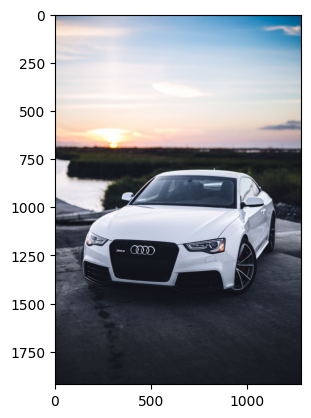

In [65]:
url = "https://i.pinimg.com/originals/13/9e/48/139e48f39ada07c430b33ec2f671aa33.jpg"
img = Image.open(BytesIO(requests.get(url).content)).convert('RGB')
plt.imshow(img)
question = "is there sunset?"

answer, answerability_score = test_single_example(img, question, clip_model, model_vqa, model_ans, enc)
print(f"Answer: {answer.item()}")
print(f"Answerability Confidence: {answerability_score.item()*100:.3f}%\n")

Answer: blue
Answerability Confidence: 99.267%



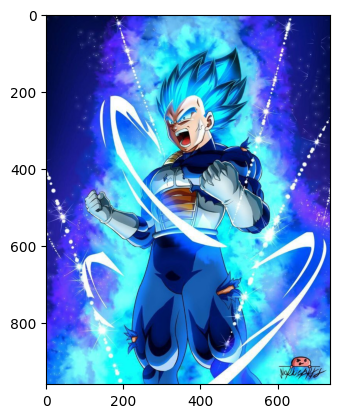

In [66]:
url2 = "https://i.pinimg.com/originals/be/c0/9f/bec09fe372a8c8f046fafe3c716c25d3.jpg"
img2 = Image.open(BytesIO(requests.get(url2).content)).convert('RGB')
plt.imshow(img2)
question2 = "what is the color in the image?"

answer2, answerability_score2 = test_single_example(img2, question2, clip_model, model_vqa, model_ans, enc)
print(f"Answer: {answer2.item()}")
print(f"Answerability Confidence: {answerability_score2.item()*100:.3f}%\n")

Answer: unanswerable
Answerability Confidence: 78.144%



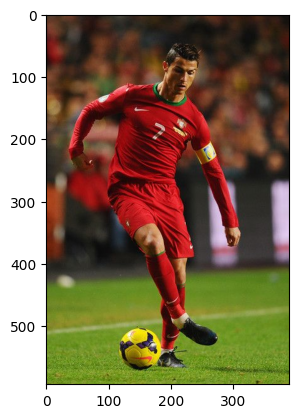

In [73]:
url3 = "https://i.pinimg.com/originals/e8/5f/c9/e85fc9ba1f74bf38f5c7fbd0043ddd2d.jpg"
img3 = Image.open(BytesIO(requests.get(url3).content)).convert('RGB')
plt.imshow(img3)
question3 = "is there any athelete?"

answer3, answerability_score3 = test_single_example(img3, question3, clip_model, model_vqa, model_ans, enc)
print(f"Answer: {answer3.item()}")
print(f"Answerability Confidence: {answerability_score3.item()*100:.3f}%\n")